In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import math

In [81]:
class CosineScheduler():
    def __init__(
        self,
        lr_warmup_steps: int,
        lr: float,
        final_lr_step: int,
        final_lr_fraction: float,
    ):
        self.lr_warmup_steps = lr_warmup_steps
        self.lr = lr
        self.final_lr_step = final_lr_step
        self.final_lr_fraction = final_lr_fraction

    def get_lr(self, step: int, start_lr=None, end_lr=None):
        start_lr = start_lr if start_lr is not None else self.lr
        end_lr = end_lr if end_lr is not None else self.lr * self.final_lr_fraction

        if step < self.lr_warmup_steps:
            return start_lr * (step + 1) / self.lr_warmup_steps
        # cosine schedule that ends at final_lr_fraction * lr, then constant
        elif step < self.final_lr_step:
            return end_lr + 0.5 * (1 - end_lr/start_lr) * start_lr * (
                1
                + math.cos(
                    math.pi
                    * (step - self.lr_warmup_steps)
                    / (self.final_lr_step - self.lr_warmup_steps)
                )
            )
        else:
            return end_lr

    # had to overwrite it here, because AbstractLRScheduler doesn't know final_lr_fraction and othr params necessary for relative lr fractions
    def set_lr(self, step: int):
        
        start_lr = self.lr
        end_lr = self.lr * self.final_lr_fraction
        return self.get_lr(step, start_lr=start_lr, end_lr=end_lr)

In [82]:
# Load the gradient data from CSV files
# Adjust filenames as needed
keyword = 'gradient'
attention_filenames = [f'/home/jan.malasnicki/Downloads/scaled_{keyword}_norm_encoder_blocks_block_{i}_block_residual_attention_layer_attention_output_projection_weight.csv' for i in range(8)]
expert_filenames = [f'/home/jan.malasnicki/Downloads/scaled_{keyword}_norm_encoder_blocks_block_{i}_block_residual_feedforward_layer_feedforward_expert_inner_function_lin1_weight.csv' for i in range(8)]
router_filenames = [f'/home/jan.malasnicki/Downloads/scaled_{keyword}_norm_encoder_blocks_block_{i}_block_residual_feedforward_layer_feedforward_gating_gate.csv' for i in range(8)]
embed_filenames = [f'/home/jan.malasnicki/Downloads/scaled_{keyword}_norm_embedding_layer_layers_0_weight.csv' for i in range(8)]
head_filenames = [f'/home/jan.malasnicki/Downloads/scaled_{keyword}_norm_head_weight.csv' for i in range(8)]

# Load CSVs and assign column names
column_names = ['Step', 'Placeholder', 'Gradient Norm']
attention_dfs = [pd.read_csv(filename, header=None, names=column_names) for filename in attention_filenames]
expert_dfs = [pd.read_csv(filename, header=None, names=column_names) for filename in expert_filenames]
router_dfs = [pd.read_csv(filename, header=None, names=column_names) for filename in router_filenames]
embed_dfs = [pd.read_csv(filename, header=None, names=column_names) for filename in embed_filenames]
head_dfs = [pd.read_csv(filename, header=None, names=column_names) for filename in head_filenames]

scheduler = CosineScheduler(
    lr_warmup_steps=150,
    lr=0.001,
    final_lr_fraction=0.066666,
    final_lr_step=15000
    )

# normalize = attention_dfs[0].loc[4, 'Gradient Norm']
# for df in attention_dfs:
#     df['Normalized Gradient Norm'] = df['Gradient Norm'] / normalize

# multiplier_router = 0.01
# for df in router_dfs:
#     df['Gradient Norm'] *= multiplier_router

# multiplier_embed = 6
# for df in embed_dfs:
#     df['Gradient Norm'] *= multiplier_embed

# multiplier_head = 0.2
# for df in head_dfs:
#     df['Gradient Norm'] *= multiplier_head


In [83]:
for df in attention_dfs:
    df['Normalized Gradient Norm'] = df.apply(lambda row: row['Gradient Norm'] / scheduler.set_lr(row['Step']), axis=1)

for df in router_dfs:
    df['Normalized Gradient Norm'] = df.apply(lambda row: row['Gradient Norm'] / scheduler.set_lr(row['Step']), axis=1)

for df in embed_dfs:
    df['Normalized Gradient Norm'] = df.apply(lambda row: row['Gradient Norm'] / scheduler.set_lr(row['Step']), axis=1)

for df in head_dfs:
    df['Normalized Gradient Norm'] = df.apply(lambda row: row['Gradient Norm'] / scheduler.set_lr(row['Step']), axis=1)

for df in expert_dfs:
    df['Normalized Gradient Norm'] = df.apply(lambda row: row['Gradient Norm'] / scheduler.set_lr(row['Step']), axis=1)


In [84]:
# # Define a function to plot a single subplot
# def plot_gradient_norms(ax, df, title, column='Normalized Gradient Norm', normalize=True):
#     steps = df['Step'].values
#     grad_norms = df[column].values
#     if normalize:
#         grad_norms /= df[column].median()
#     ax.plot(steps, grad_norms, label=column)
#     ax.set_xlabel('Training Step')
#     ax.set_ylabel(column)
#     ax.set_title(title)
#     ax.grid(True)

def plot_gradient_norms(ax, df, title, column='Gradient Norm', normalize=True):
    # Filter out the row where Step == 0
    df_filtered = df[df['Step'] != 0]

    # Extract steps and gradient norms from the filtered DataFrame
    steps = df_filtered['Step'].values
    grad_norms = df_filtered[column].values

    # Normalize if needed
    if normalize:
        grad_norms /= df_filtered[column].median()

    # Plot the data
    ax.plot(steps, grad_norms, label=column)
    ax.set_xlabel('Training Step')
    ax.set_ylabel(column)
    ax.set_title(title)
    ax.grid(True)


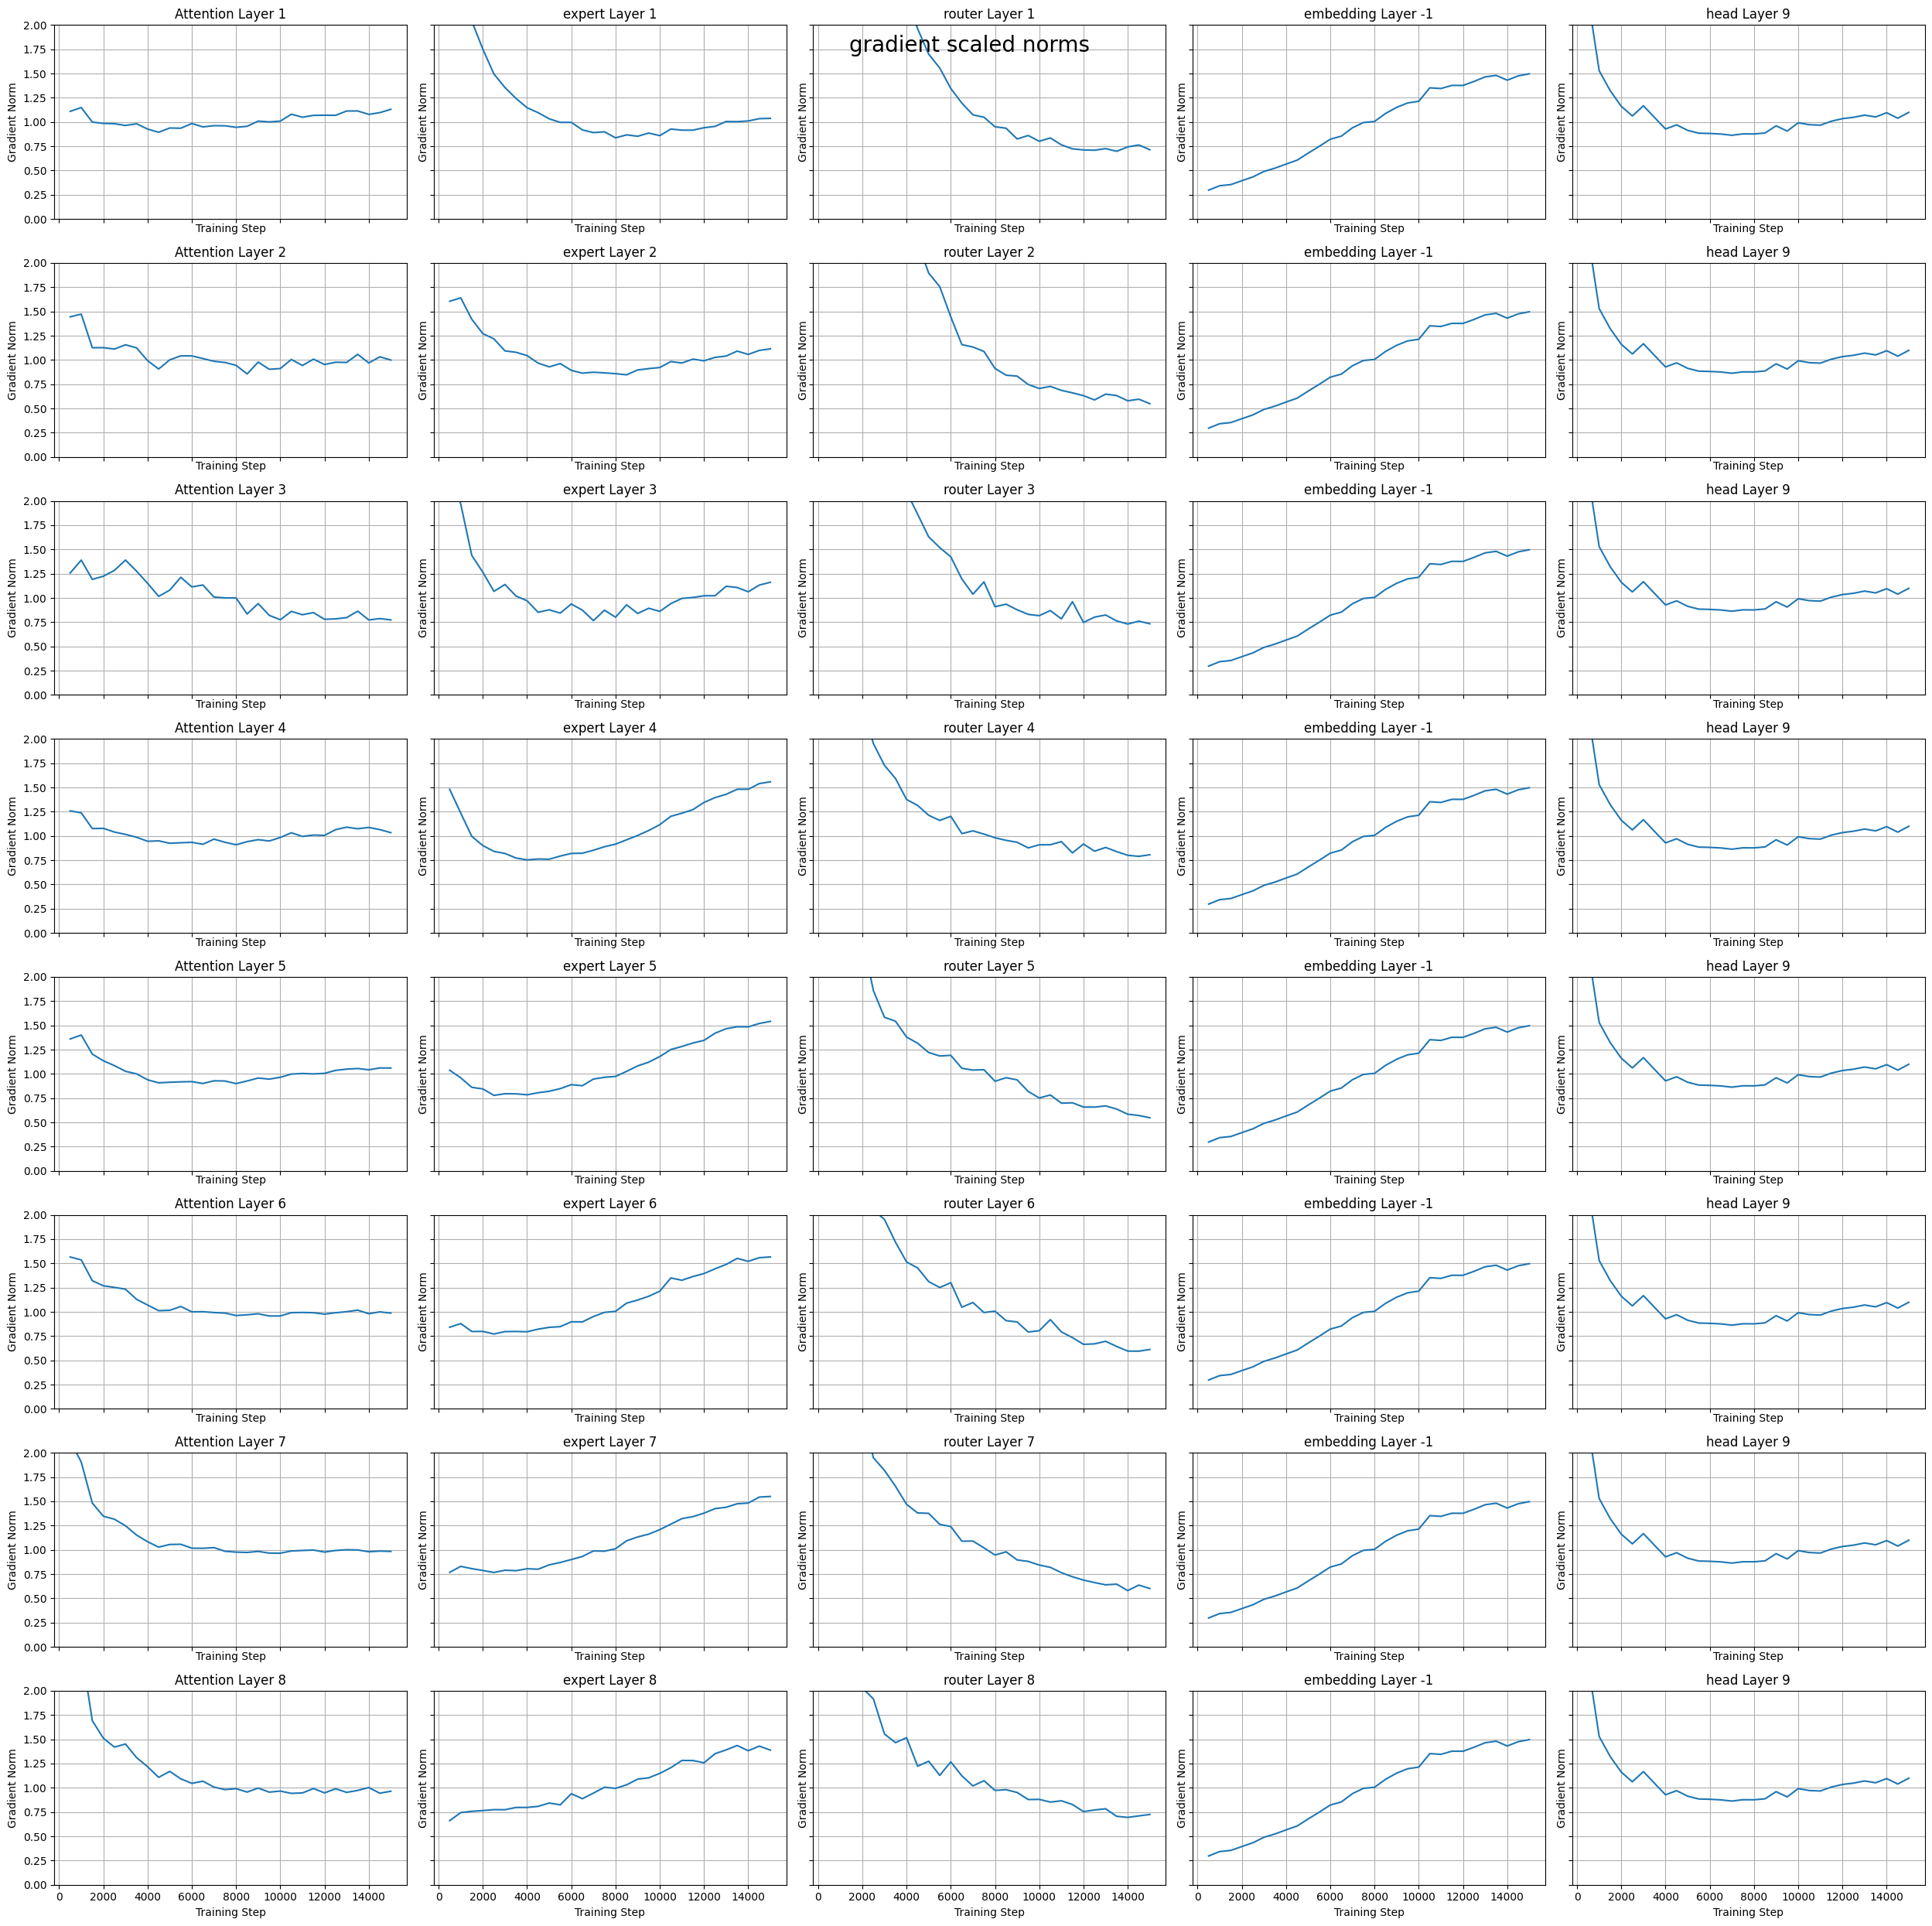

In [85]:
# Create a figure with 16 subplots (8 rows and 2 columns)
fig, axes = plt.subplots(8, 5, figsize=(25, 25), sharex=True, sharey=True)

# Plot Attention gradients
for i, df in enumerate(attention_dfs):
    plot_gradient_norms(axes[i, 0], df, f'Attention Layer {i+1}')

# Plot expert gradients
for i, df in enumerate(expert_dfs):
    plot_gradient_norms(axes[i, 1], df, f'expert Layer {i+1}')

# Plot router gradients
for i, df in enumerate(router_dfs):
    plot_gradient_norms(axes[i, 2], df, f'router Layer {i+1}')

# Plot embed gradients
for i, df in enumerate(embed_dfs):
    plot_gradient_norms(axes[i, 3], df, f'embedding Layer {-1}')

# Plot head gradients
for i, df in enumerate(head_dfs):
    plot_gradient_norms(axes[i, 4], df, f'head Layer {9}')

# Adjust layout
plt.ylim(0, 2)
plt.tight_layout()
fig.suptitle(f'{keyword} scaled norms', fontsize=20)
plt.savefig(f'{keyword}_norms.png')
plt.show()